In [1]:
!pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git"

  Cloning https://github.com/ibm-granite/granite-tsfm.git to /private/var/folders/61/bmwhyqss6rjdhl37b33pbz9m0000gn/T/pip-install-h_5o6uxj/tsfm-public_83f3839963a8443889aaacd3ac77e8ef
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /private/var/folders/61/bmwhyqss6rjdhl37b33pbz9m0000gn/T/pip-install-h_5o6uxj/tsfm-public_83f3839963a8443889aaacd3ac77e8ef
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit f51b65e527aa3403a0c95d224e471655ed8e04c7
  Installing build dependencies ... one
  Getting requirements to build wheel ... one
  Preparing metadata (pyproject.toml) ... done


In [2]:
#pip install torch --upgrade

In [3]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
import tsfm_public
import matplotlib.pyplot as plt

In [4]:
tsfm_public.__version__

'0.2.18.dev73+gf51b65e'

# NOTE
1. This is an initial version of forecasting done with IBM TTM Models.
1. Needs more understanding about its inner workings before we can start to compare it with pdmarima:
   - How does it split the data into test/train/validate
   - and why can we not align index 685 of raw data with index 685 of TTM output etc
   - most likely trivial issues which just needs to be figured out by reading more about TTM

In [5]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
#target_dataset = "ettm2"
#DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

### - DO WE NEED BELOW ? ####

# Forecasting parameters
#context_length = 512
#forecast_length = 96
#fewshot_fraction = 0.05


# ----- TTM model branch -----
# For R2 models
#TTM_MODEL_REVISION = "main"
# TTM_MODEL_REVISION="1024-96-r2"
# TTM_MODEL_REVISION="1536-96-r2"


In [6]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

In [7]:
# Load the data file and see the columns
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [8]:
data.shape

(17420, 8)

<Axes: xlabel='date'>

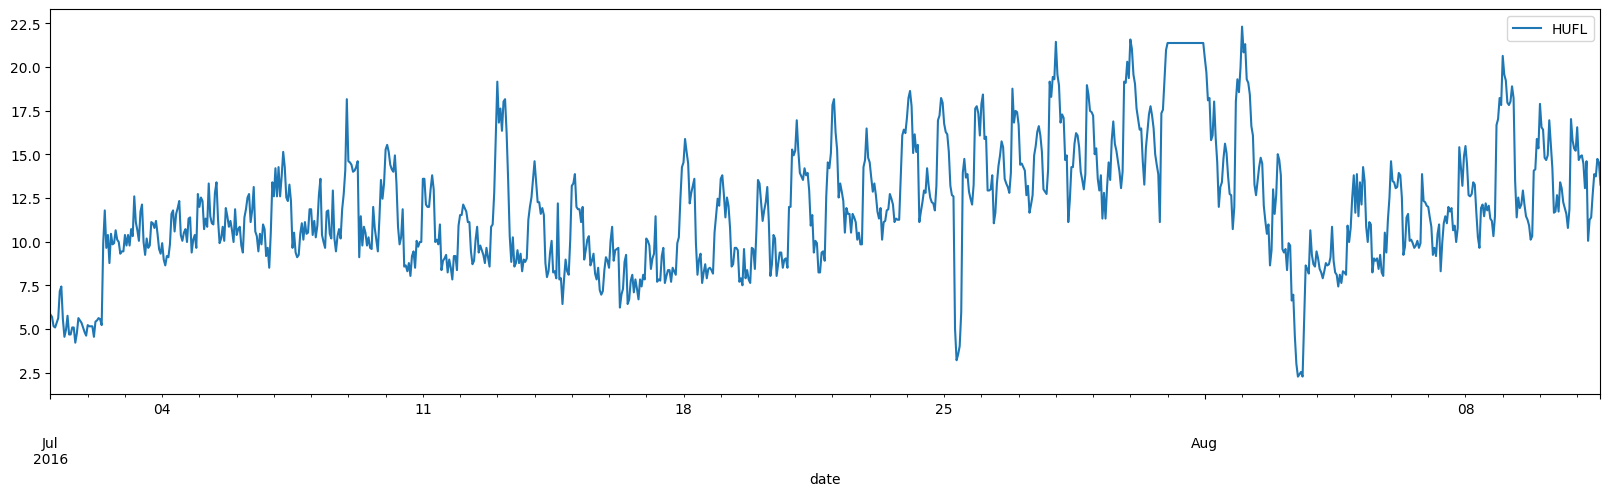

In [9]:
data.iloc[:1000].plot(x="date", y="HUFL", figsize=(20, 5))

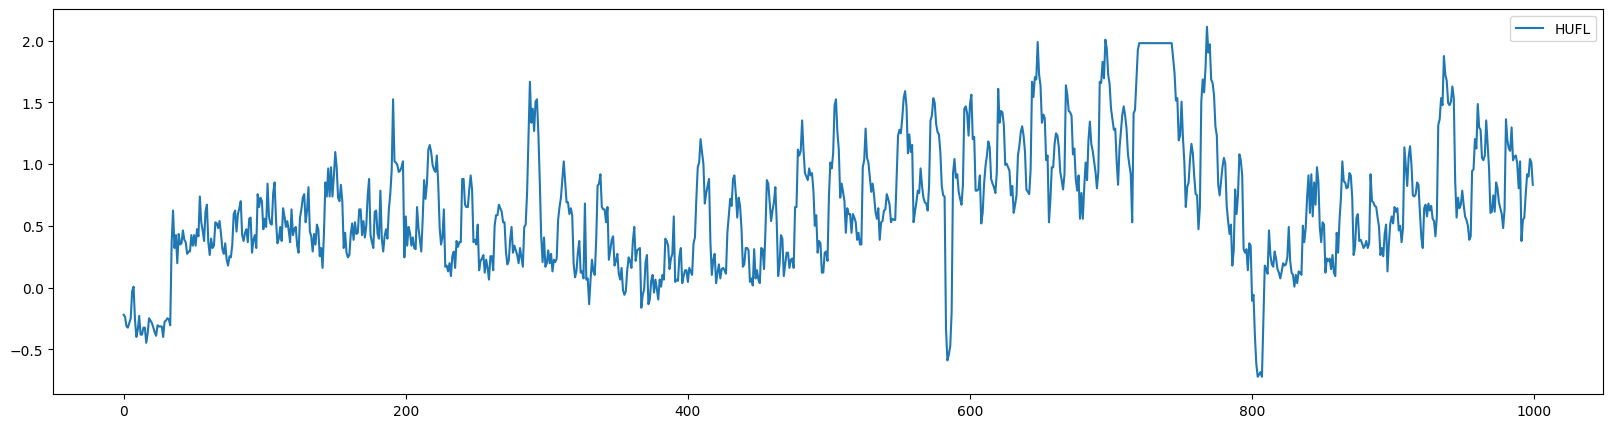

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to scale (exclude date column)
columns_to_scale = ["HUFL"]

# Fit and transform the selected columns
data_scaled = scaler.fit_transform(data[columns_to_scale])

plt.figure(figsize=(20,5))
plt.plot(data_scaled[0:1000], label="HUFL")
plt.legend()
plt.show()

In [11]:
#tsp = TimeSeriesPreprocessor(
#    **column_specifiers,
#    context_length=context_length,
#    prediction_length=forecast_length,
#    scaling=True,
#    encode_categorical=False,
#    scaler_type="standard",
#)

## This is new
#train_dataset, valid_dataset, test_dataset = get_datasets(
#    tsp, data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first")
#print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

In [12]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config)
    print(f"Data lengths: train = {len(dset_train)}, val = {len(dset_valid)}, test = {len(dset_test)}")

    # Load model
    zeroshot_model = get_model(TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length)

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )


    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print("Zeroshot output:")
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print("Prediction Shape:")
    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print("Backbone Embedding Shape:")
    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        #indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        indices=[685, 118,],
        channel=0,
    )

INFO:p-80765:t-8664588800:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-80765:t-8664588800:get_model.py:get_model:Selected TTM `prediction_length` = 96


Data lengths: train = 8033, val = 2785, test = 2785


INFO:p-80765:t-8664588800:get_model.py:get_model:Model loaded successfully!
INFO:p-80765:t-8664588800:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


Zeroshot output:
{'eval_loss': 0.3628121316432953, 'eval_model_preparation_time': 0.0013, 'eval_runtime': 2.5317, 'eval_samples_per_second': 1100.051, 'eval_steps_per_second': 17.38}
Prediction Shape:
(2785, 96, 7)
Backbone Embedding Shape:
(2785, 7, 8, 192)


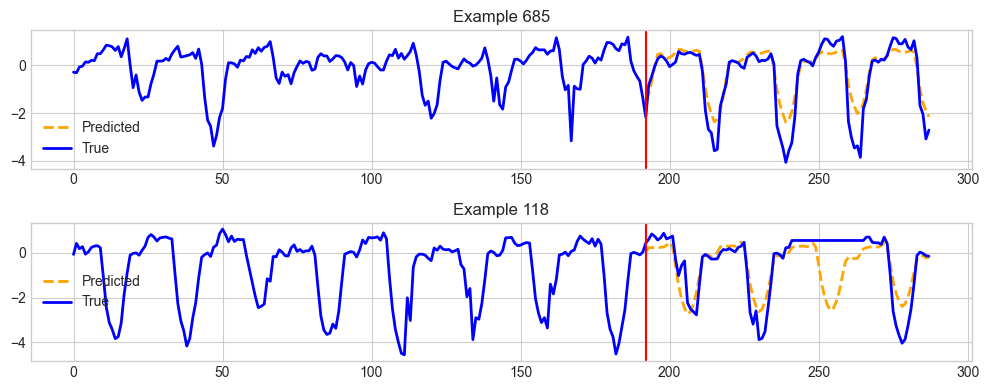

In [13]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

In [14]:
print(data.shape)
data.head()
data_300 = data.iloc[685:985]

(17420, 8)


HUFL


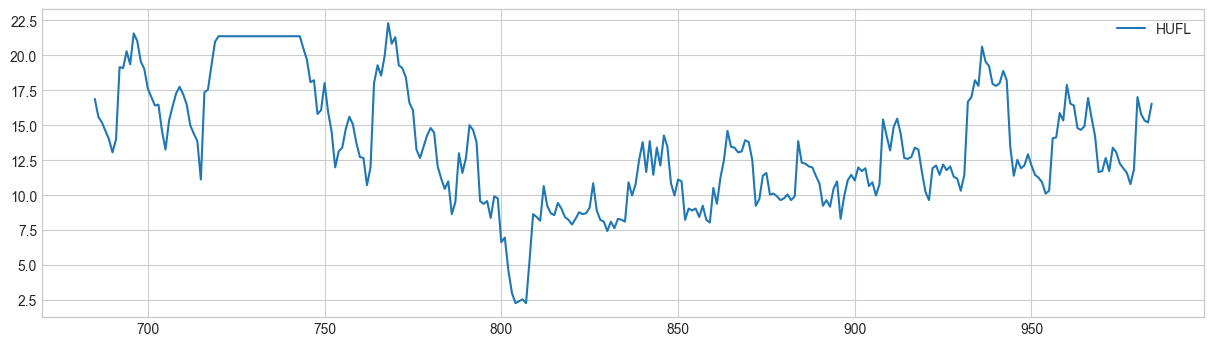

In [15]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(20, 6))
#channel =0 is first variable HUFL
#y = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
y = [  "HUFL"]
for i in y:
    plt.figure(figsize=(15, 4))
    print(i)
    plt.plot(data_300[i], label=i)
    plt.legend()
    plt.show()



In [16]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    dset_train, dset_val, dset_test = get_datasets(
        tsp, data, split_config, fewshot_fraction=fewshot_percent / 100, fewshot_location="first"
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            loss=loss,
            quantile=quantile,
        )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

INFO:p-80765:t-8664588800:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-80765:t-8664588800:get_model.py:get_model:Selected TTM `prediction_length` = 96


-------------------- Running few-shot 5% --------------------


INFO:p-80765:t-8664588800:get_model.py:get_model:Model loaded successfully!
INFO:p-80765:t-8664588800:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96
/Users/jbanerje/code/acm-inspector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


INFO:p-80904:t-8673346048:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80905:t-8647619072:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80909:t-8669114880:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80910:t-8605905408:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80916:t-8645345792:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80917:t-8674017792:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80920:t-8679703040:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80922:t-8673255936:config.py:<module>:PyTorch version 2.2.2 available.


Epoch,Training Loss,Validation Loss
1,0.800300,0.663651
2,0.790400,0.663002
3,0.743100,0.662511
4,0.735100,0.662228
5,0.721600,0.662516
6,0.690600,0.664811
7,0.655100,0.670114
8,0.631500,0.689885
9,0.605400,0.698759
10,0.594200,0.690102


INFO:p-80934:t-8637006336:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80935:t-8602157568:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80938:t-8612835840:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80940:t-8636121600:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80944:t-8614408704:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80946:t-8673509888:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80949:t-8606986752:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80950:t-8608858624:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80970:t-8680276480:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80977:t-8646222336:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80980:t-8610984448:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80982:t-8602948096:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-80986:t-8647528960:config.py:<module>:PyTorch version 2.2

[TrackingCallback] Mean Epoch Time = 44.63764716897692 seconds, Total Train Time = 1479.7733478546143
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


INFO:p-82502:t-8634012160:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82503:t-8608764416:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82507:t-8601174528:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82508:t-8669667840:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82511:t-8612639232:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82514:t-8613638656:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82517:t-8611774976:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82519:t-8680071680:config.py:<module>:PyTorch version 2.2.2 available.


{'eval_loss': 0.3619941174983978, 'eval_runtime': 60.4616, 'eval_samples_per_second': 46.062, 'eval_steps_per_second': 0.728, 'epoch': 14.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


INFO:p-82547:t-8682529280:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82549:t-8681427456:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82553:t-8671441408:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82554:t-8677499392:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82557:t-8679821824:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82559:t-8680235520:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82562:t-8674972160:config.py:<module>:PyTorch version 2.2.2 available.
INFO:p-82564:t-8678248960:config.py:<module>:PyTorch version 2.2.2 available.


(2785, 96, 7)
(2785, 7, 8, 192)


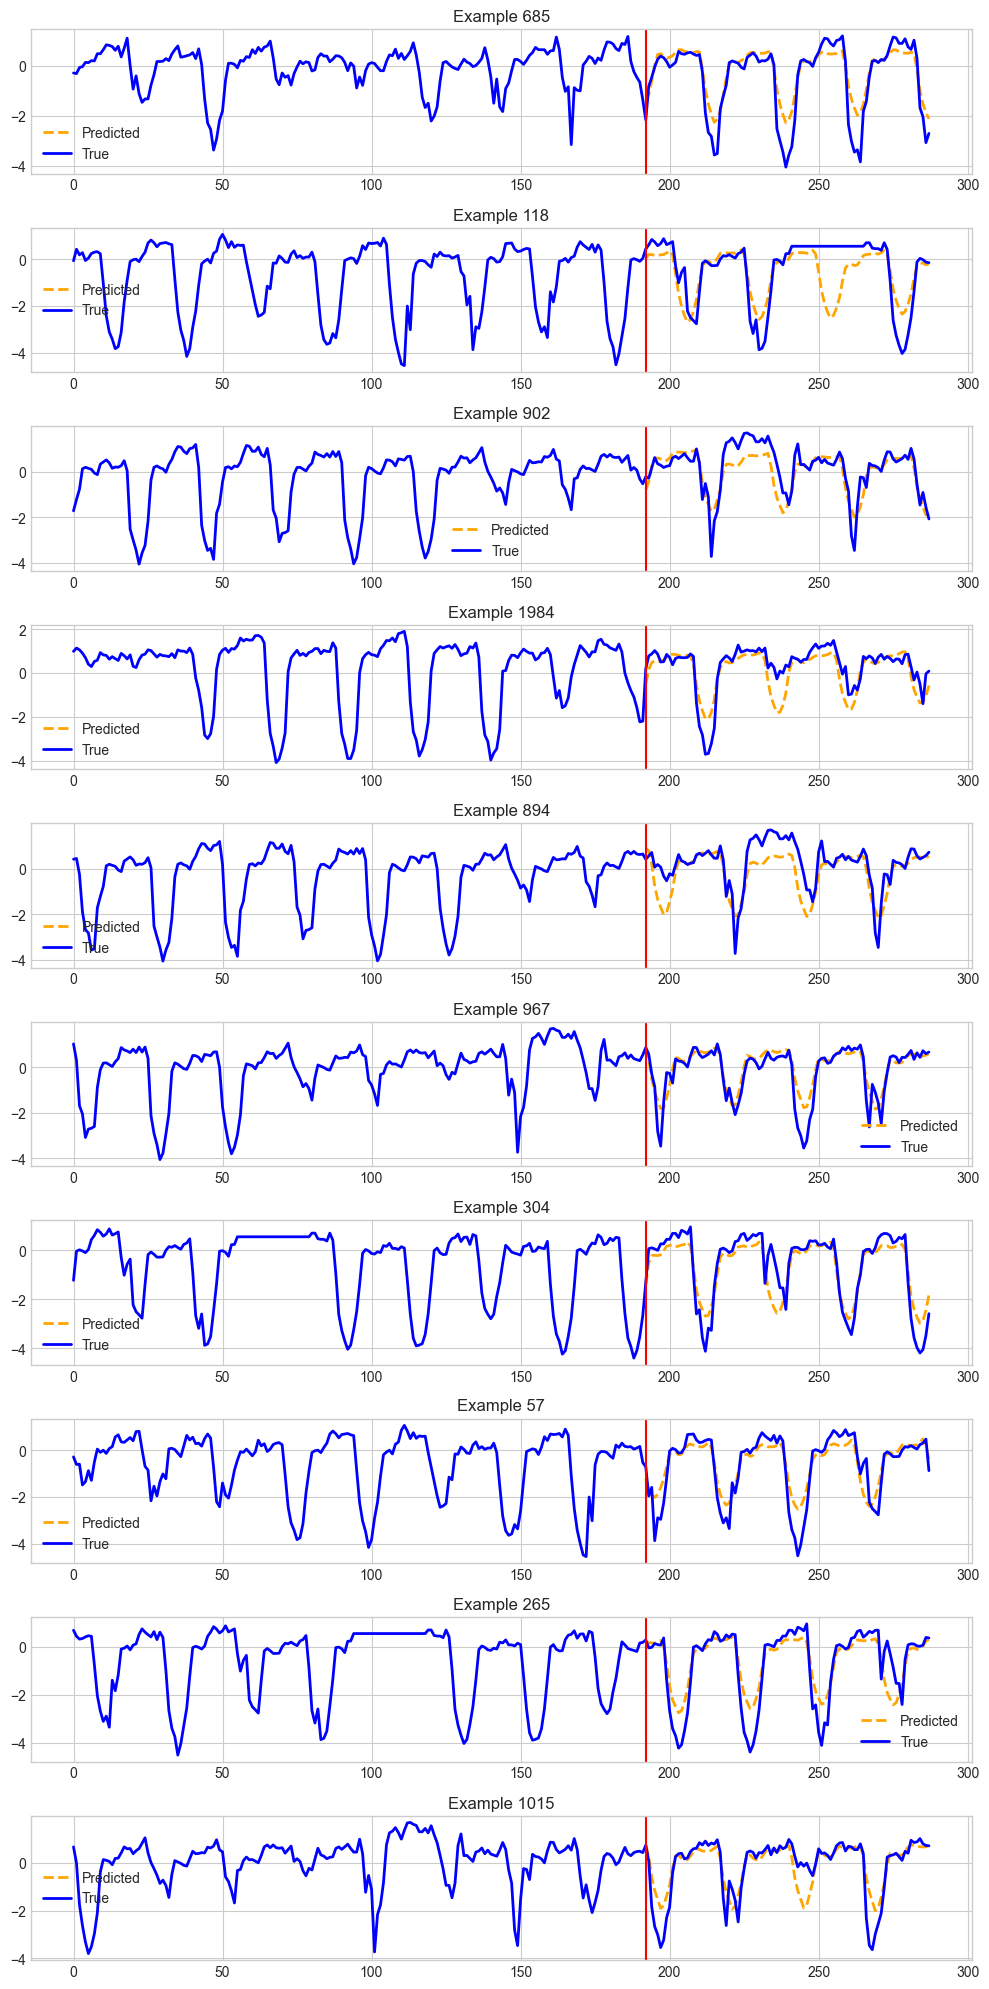

In [17]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)